In [1]:
# Setup and Import data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Import Data
url = 'F:\Education\BITS Pilani\Semester-4\R&D\\batch_completion.csv'

df = pd.read_csv(url, parse_dates=['date'], index_col='date')

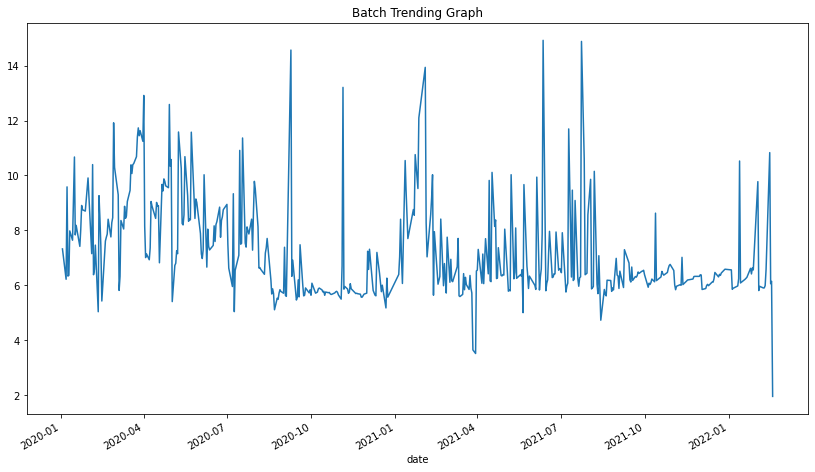

In [4]:
# Plot graph
series = df.loc[:, 'value'].values
df.plot(figsize=(14,8), legend=None, title='Batch Trending Graph');

In [5]:
# Seasonal trend
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.date]
df['month'] = [d.month for d in df.date]
df['day'] = [d.day for d in df.date]
months = df['month'].unique()

# Prep Colors
#np.random.seed(100)
#mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(months), replace=False)

# Draw Plot
#plt.figure(figsize=(16,12), dpi= 80)
#for i, y in enumerate(months):
#    if i > 0:        
#        plt.plot('day', 'value', data=df.loc[df.month==y, :], color=mycolors[i], label=y)
#        plt.text(df.loc[df.month==y, :].shape[0]-.9, df.loc[df.month==y, 'value'][-1:].values[0], y, fontsize=12, color=mycolors[i])

# Decoration
#plt.gca().set(xlim=(-0.3, 30), ylim=(2, 20), ylabel='$Batch Completion$', xlabel='$Day$')
#plt.yticks(fontsize=12, alpha=.7)
#plt.title("Seasonal Plot of Batch SLA Time Series", fontsize=20)
#plt.show()

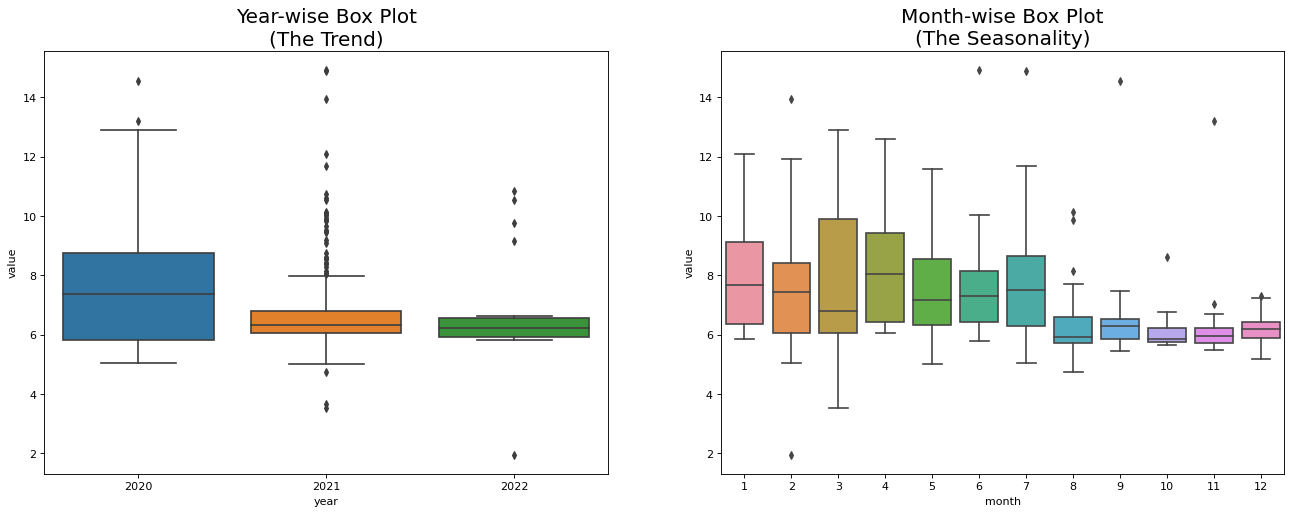

In [6]:
# Box plots
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='value', data=df, ax=axes[0])
sns.boxplot(x='month', y='value', data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

In [8]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

data = pd.read_csv(url, parse_dates=['date'], index_col='date')

# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][:-36],   # 3 years
                                model='multiplicative',
                                period=12,
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['day'] = pd.to_datetime(seasonal_index.index).day

# merge with the base data
data['day'] = data.index.day
df = pd.merge(data, seasonal_index, how='left', on='day')
df.columns = ['value', 'day', 'seasonal_index']
df.index = data.index  # reassign the index.

In [9]:
# Remove NaN values for seasonal index
df['seasonal_index'] = df['seasonal_index'].fillna(0)

In [10]:
# SARIMAX Model
import pmdarima as pm
sxmodel = pm.auto_arima(df[['value']], ##exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2044.496, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1851.102, Time=0.38 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2042.592, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2002.328, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1813.014, Time=0.83 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.77 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1874.138, Time=0.96 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1808.532, Time=1.10 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1846.841, Time=0.41 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=4.77 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=1809.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  474
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 12)   Log Likelihood                -893.946
Date:                             Fri, 06 May 2022   AIC                           1799.891
Time:                                     13:36:25   BIC                           1824.705
Sample:                                          0   HQIC                          1809.660
                                             - 474                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0409      0.121      8.603      0.000       0.804       1.278
ar.L2         -0.1382      0.074     -1.870      0.061      -0.283       0.007
ma.L1         -0.7470      0.111     -6.707      0.000      -0.965      -0.529
ar.S.L12      -0.7233      0.043    -16.756      0.000      -0.808      -0.639
ar.S.L24      -0.3060      0.042     -7.210      0.000      -0.389      -0.223
sigma2         2.7662      0.102     27.013      0.000       2.565       2.967
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               517.42
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                             1.25
Prob(H) (two-sided):                  0.51   Kurtosis:                         7.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

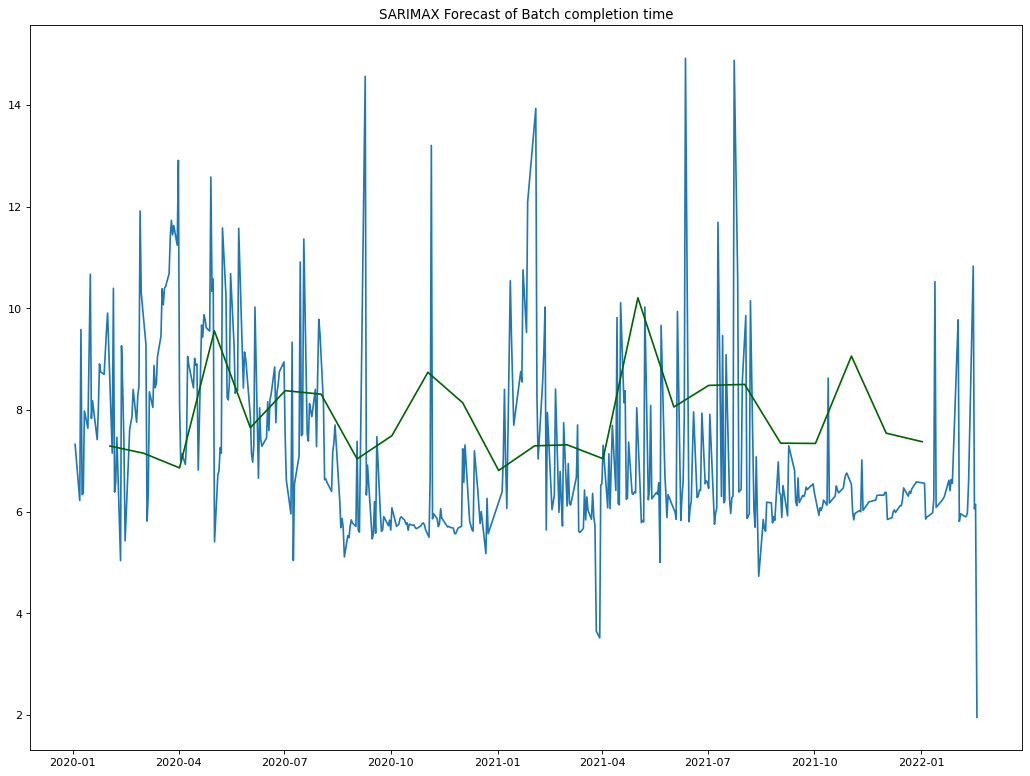

In [11]:
# Forecast
n_periods = 24
##fitted, confint = sxmodel.predict(n_periods=n_periods, exogenous=np.tile(seasonal_index.seasonal, 2).reshape(-1,1), return_conf_int=True)
fitted = sxmodel.predict(n_periods=n_periods)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
##lower_series = pd.Series(confint[:, 0], index=index_of_fc)
##upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(16,12), dpi= 80)
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
##plt.fill_between(##lower_series.index, 
                 ##lower_series, 
                 ##upper_series, 
                 ##color='k', alpha=.15)

plt.title("SARIMAX Forecast of Batch completion time")
plt.show()

In [12]:
# Accuracy metrics
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fitted-df.value[-24:])[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fitted, df.value[-24:])

<ipython-input-12-02627578915a>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-12-02627578915a>:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


{'mape': 0.09894142148524827,
 'me': -0.27618639904571834,
 'mae': 0.7997802376217056,
 'mpe': -0.020520681538498207,
 'rmse': 0.9365885593783937,
 'acf1': 0.3301260444956988,
 'corr': 0.7277836839680543,
 'minmax': 0.0942893264063075}

In [13]:
import pickle

# Save the trained model as a pickle string.
##saved_model = pickle.dumps(sxmodel)
 
# Load the pickled model
##sxmodel_from_pickle = pickle.loads(saved_model)
 
# Use the loaded pickled model to make predictions
##sxmodel_from_pickle.predict(12)

# Serialize with Pickle
with open('forecast.pkl', 'wb') as pkl:
    pickle.dump(sxmodel, pkl)

In [14]:
import joblib

# Save the model as a pickle in a file
joblib.dump(sxmodel, 'forecast.pkl')
 
# Load the model from the file
sxmodel_from_joblib = joblib.load('forecast.pkl')
 
# Use the loaded model to make predictions
sxmodel_from_joblib.predict(12)

array([7.29275171, 7.15032792, 6.86231061, 9.55760317, 7.65225991,
       8.38128034, 8.31239127, 7.0379847 , 7.49513224, 8.74247311,
       8.14328606, 6.81087367])